In [1]:
import requests
import io
import zipfile

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Na początku robimy to samo co w pracy domowej 1

tylko tym razem w Pythonie...

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as tmp_zip:
    for zip_file in tmp_zip.infolist():
        with tmp_zip.open(zip_file, 'r') as f:
            stata_file = io.BytesIO(f.read())

In [3]:
stata_file.seek(0)
data = pd.read_stata(stata_file)

# Obrabiamy dane jak poprzednio


In [4]:
data = data[['S1', 'Q9', 'Q19', 'Q26', 'ppage']]

In [5]:
for column in data.columns:
    data = data[data[column] != 'Refused']
    data[column].cat.remove_unused_categories()
data = data.dropna()
data[['Q9', 'ppage']] = data[['Q9', 'ppage']].apply(pd.to_numeric, axis=1)

In [6]:
data.sample(5)

,S1,Q9,Q19,Q26,ppage
3370,"Yes, I am Married",34.0,Yes,Did not attend same college or university,29.0
164,"No, I am not Married",50.0,Yes,Did not attend same college or university,53.0
1009,"Yes, I am Married",27.0,Yes,Did not attend same college or university,26.0
1365,"Yes, I am Married",48.0,Yes,Did not attend same college or university,47.0
2467,"Yes, I am Married",46.0,Yes,Attended same college or university,44.0


In [7]:
y = data['S1']
x = data.drop('S1', axis=1)

# Robimy model

In [8]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

le_q19 = LabelEncoder()
x['Q19'] = le_q19.fit_transform(x['Q19'])

le_q26 = LabelEncoder()
x['Q26'] = le_q26.fit_transform(x['Q26'])

In [9]:
ohe = OneHotEncoder(categorical_features=[1, 2], 
                    dtype=np.int64,
                    sparse=False)
x = pd.DataFrame(ohe.fit_transform(x.values))
x.columns = ['Q9_0', 'Q9_1', 'Q19_0', 'Q19_1', 'Q26', 'ppage']

In [10]:
x.head()

,Q9_0,Q9_1,Q19_0,Q19_1,Q26,ppage
0,0.0,1.0,0.0,1.0,52.0,55.0
1,0.0,1.0,0.0,1.0,45.0,47.0
2,0.0,1.0,0.0,1.0,59.0,59.0
3,0.0,1.0,0.0,1.0,65.0,65.0
4,0.0,1.0,0.0,1.0,43.0,33.0


In [11]:
rfc = RandomForestClassifier(max_depth=4,
                             n_estimators=30,
                             max_features=None)
rfc.fit(x, y)

y_pred = rfc.predict(x)
accuracy_score(y, y_pred)

0.8755527479469362

# Wyjaśniamy model wykresami CP

In [12]:
class CeterisParibusPlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_ceteris_paribus_plot(self, observation, column):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        original_position = observation[column].loc[0]
        ranges = []
        scores = []
        i = 0
        
        # find scores for all hypotetical observations
        for value in range(mini, maxi + 1):
            observation[column] = value
            score = self.clf.predict_proba(observation)[0, 1]
            if value == original_position:
                original_score = score
                
            scores.append(score)
            ranges.append(i)
            i += 1

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=scores)
        ax.set_title('Ceteris Paribus profile for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.scatter(x=[original_position], y=[original_score], marker='o', s=100)
        plt.show()
        
        return


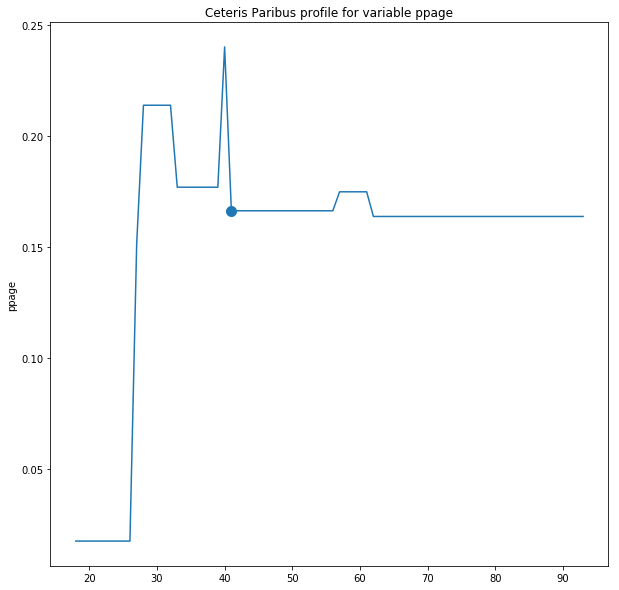

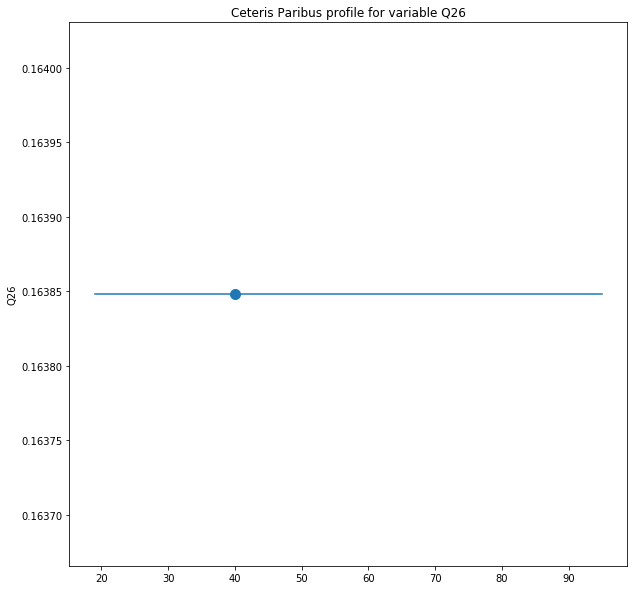

In [13]:
joe = pd.DataFrame({'Q9_0': [0], 'Q9_1': [1], 'Q19_0': [1], 'Q19_1': [0], 'Q26': [40], 'ppage': [41]})

cpp = CeterisParibusPlotter(rfc, x)
cpp.draw_ceteris_paribus_plot(joe, 'ppage')
cpp.draw_ceteris_paribus_plot(joe, 'Q26')

# Tutaj zaczyna się część właściwa

dodajemy wykres Accumulated Local Effects

In [14]:
class AccumulatedLocalEffectsPlotter(CeterisParibusPlotter):
    def draw_accumulated_local_effects_plot(self, column, window_size=1):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        ale = []
        
        # find ALE statistics
        for value in range(mini, maxi + 1):
            neighbours = self.x[(self.x[column] >= value - window_size) &
                                (self.x[column] <= value + window_size)].copy()
            
            neighbours[column] = value - window_size
            scores_lower = self.clf.predict_proba(neighbours)[:, 1]
            
            neighbours[column] = value + window_size
            scores_upper = self.clf.predict_proba(neighbours)[:, 1]
            
            
            ale.append((scores_upper - scores_lower).mean())
        
        ale = np.array(ale).cumsum()
        ale = ale - np.array(ale).mean()

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=ale)
        ax.set_title('Accumulated Local Effects plot for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.show()
        return


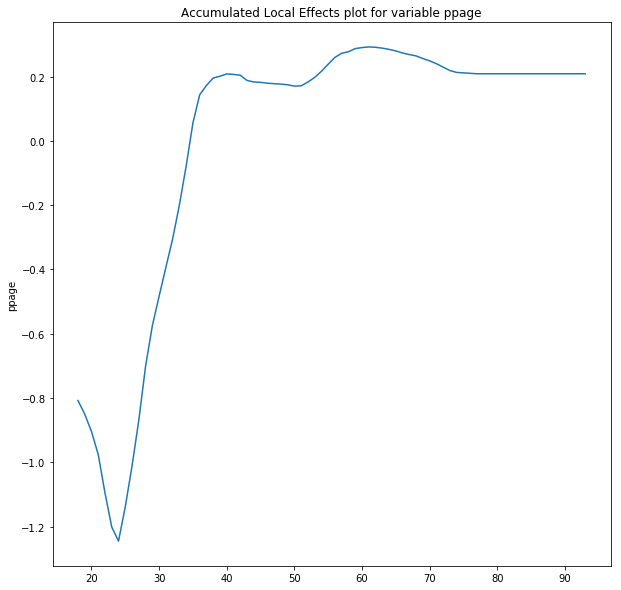

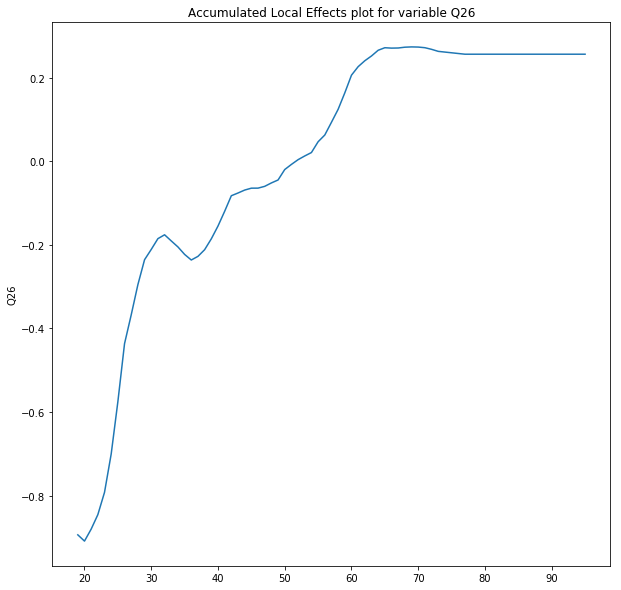

In [15]:
alep = AccumulatedLocalEffectsPlotter(rfc, x)
alep.draw_accumulated_local_effects_plot('ppage', 3)
alep.draw_accumulated_local_effects_plot('Q26', 3)

In [16]:
print(x[['ppage', 'Q26']].corr())

          ppage       Q26
ppage  1.000000  0.924767
Q26    0.924767  1.000000


Wybrany przeze mnie przykład jest ciekawy, ponieważ mamy do czynienia z wysoce skorelowanymi predyktorami. Poziom skorelowania jest tak duży, że nauczony las losowy pomija w predykcji zmienną Q26, która cechuje się płaskim profilem CP.

Przy zastosowaniu technik uwzględniających korelację pomiędzy zmiennymi widoczne jest podobieństwo pomiędzy profilami CP oraz ALE dla zmiennej ppage. W przypadku zmiennej Q26 widoczna krzywa jest efektem losowego doboru sąsiadów o różnych wartościach pozostałyc zmiennych objaśniających. Dynamika wykresujest jest zbliżona do poprzedniego, jest to jednak efekt pozorny, gdyż zmienna Q26 nie bierze de facto udziału w procesie scorowania! Myślę, że jest to ważna pułapka, w którą może wpaść osoba nieuważnie stosujące omawiane na zajęciach techniki.